In [1]:
import tensorflow as tf
import numpy as np
import gym
from tensorflow.keras.models import load_model

In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
env = gym.make("LunarLander-v2")
#env = gym.make("CartPole-v0")

In [ ]:
class model(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.d1 = tf.keras.layers.Dense(256,activation='relu')
    self.d2 = tf.keras.layers.Dense(256,activation='relu')
    self.out = tf.keras.layers.Dense(4,activation=None)

  def call(self, input_data):
    x = self.d1(input_data)
    x = self.d2(x)
    x = self.out(x)
    return x



  def action_value(self, state):
        q_values = self.predict(state)
        return q_values

In [5]:
class experience():
  def __init__(self, buffer_size, state_dim):
    self.buffer_size = buffer_size
    self.pointer = 0
    self.state_mem = np.zeros((self.buffer_size, *state_dim), dtype=np.float32)
    self.action_mem = np.zeros(self.buffer_size, dtype=np.int32)
    self.next_state_mem = np.zeros((self.buffer_size, *state_dim), dtype=np.float32)
    self.reward_mem = np.zeros(self.buffer_size, dtype=np.int32)
    self.done_mem = np.zeros(self.buffer_size, dtype=np.bool)

  def add_exp(self, state, action, reward, next_state, done):
    idx = self.pointer % self.buffer_size
    self.state_mem[idx] = state
    self.action_mem[idx] = action
    self.reward_mem[idx] = reward
    self.next_state_mem[idx] = next_state
    self.done_mem[idx] = done
    self.pointer += 1

  def sample_exp(self, batch_size):
    max_mem = min(self.pointer, self.buffer_size)
    batch = np.random.choice(max_mem, batch_size, replace= False)
    state = self.state_mem[batch]
    action = self.action_mem[batch]
    reward = self.reward_mem[batch]
    next_state = self.next_state_mem[batch]
    done = self.done_mem[batch]
    return state, action , reward, next_state, done

In [6]:
class agent():
  def __init__(self):
    self.q_net = model()
    self.target_net = model()
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    self.q_net.compile(optimizer=opt, loss='mse')
    self.target_net.compile(optimizer=opt, loss='mse')
    self.epsilon = 1.0
    self.epsilon_decay = 1e-3
    self.min_epsilon = 0.01
    self.memory = experience(buffer_size=1000000, state_dim=env.observation_space.shape)
    self.batch_size = 64
    self.gamma = 0.99
    self.replace = 100
    self.trainstep = 0
    self.action_space = [i for i in range(4)]
  def act(self, state):
    if np.random.rand() <= self.epsilon:
      #action = env.action_space.sample()
      action = np.random.choice(self.action_space)

    else:
      state = np.array([state])
      action = self.q_net.action_value(state)
      action = np.argmax(action)

    return action

  def train(self):
      if self.memory.pointer < self.batch_size:
        return 

      if self.trainstep % self.replace == 0:
        self.update_target()

      states, actions, rewards, next_states, dones = self.memory.sample_exp(self.batch_size)
      target = self.q_net.action_value(states)
      next_state_val = self.target_net.action_value(next_states)
      q_next = tf.math.reduce_max(next_state_val, axis=1, keepdims=True).numpy()
      #print("next state pred {}".format(next_state_val))
      q_target = np.copy(target)
      for i, d in enumerate(dones):
        if d:
          q_target[i, actions[i]] = rewards[i]

        else:
          #q_target[i, actions[i]] = rewards[i] + self.gamma * np.max(next_state_val[i])
          q_target[i, actions[i]] = rewards[i] + self.gamma * q_next[i]

      #print(states)
      #print(q_target)    
      self.q_net.train_on_batch(states, q_target)
      self.update_epsilon()  
      self.trainstep +=1


  def update_mem(self, state, action, reward, next_state, done):
    self.memory.add_exp(state, action, reward, next_state, done)


  def update_target(self):
    self.target_net.set_weights(self.q_net.get_weights())  


  def update_epsilon(self):
    self.epsilon = self.epsilon - self.epsilon_decay if self.epsilon > self.min_epsilon else self.min_epsilon
    return self.epsilon



  def save_model(self):
      self.q_net.save("model.h5")
      self.target_net.save("target_model.h5")


  def load_model(self):
        self.q_net = load_model("model.h5")
        self.target_net = load_model("model.h5")


In [7]:
agentoo7 = agent()
steps = 30
ep_reward = []
total_avgr = []

for s in range(steps):
  done = False
  state = env.reset()
  total_reward = 0
  t = 0
  while not done:
    #env.render()
    action = agentoo7.act(state)
    #print(action)
    next_state, reward, done, _ = env.step(action)
    agentoo7.update_mem(state, action, reward, next_state, done)
    agentoo7.train()
    state = next_state
    total_reward += reward
    t += 1
    if done:
        ep_reward.append(total_reward)
        avg_reward = np.mean(ep_reward[-10:])
        total_avgr.append(avg_reward)
        print("total reward after {} episode is {} and epsilon is {}".format(s, total_reward, agentoo7.epsilon))

total reward after 0 episode is -347.1834742469469 and epsilon is 0.981
total reward after 1 episode is -125.70929534718425 and epsilon is 0.8929999999999999
total reward after 2 episode is -183.9208249641172 and epsilon is 0.7839999999999998
total reward after 3 episode is -231.52028334705773 and epsilon is 0.6909999999999997
total reward after 4 episode is -24.558199589241738 and epsilon is 0.6089999999999997
total reward after 5 episode is -205.31931083880693 and epsilon is 0.4629999999999995
total reward after 6 episode is -27.719630732890877 and epsilon is 0.2199999999999993
total reward after 7 episode is -65.3743614643658 and epsilon is 0.02099999999999913
total reward after 8 episode is -206.01111045456184 and epsilon is 0.01
total reward after 9 episode is -104.41640588576989 and epsilon is 0.01
total reward after 10 episode is -222.6566393482246 and epsilon is 0.01
total reward after 11 episode is -214.0915126820685 and epsilon is 0.01
total reward after 12 episode is -90.033

In [8]:
import matplotlib.pyplot as plt

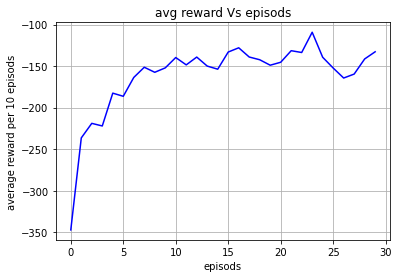

In [9]:
ep = [i  for i in range(steps)]
plt.plot(ep,total_avgr,'b')
plt.title("avg reward Vs episods")
plt.xlabel("episods")
plt.ylabel("average reward per 10 episods")
plt.grid(True)
plt.show()
